# I80: 
- Using random forest for reaction time 0.5,

- X-variables:  
1) speed of subject vechicle, 

2) Local_Y,   

3) speed differnce of subject and preceding vehicle,
 
4) space between front bumper of subject and back of preceding 

5) preceding vehicle type

6) subject vehicle type

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics    
import seaborn as sns
from pathlib import Path 
import warnings                                                 
warnings.filterwarnings("ignore")
import pyreadr
import random

In [21]:
class model():

    def createTrainPairs(df):
        '''
        Read the input file into a dataframe. 
        Input: File name for the file present in Data folder. 
        Output: Dataframe name. 
        '''
        random.seed(2109)
        pairs = df["LF_pairs"].unique()
        pairs = pairs.tolist()
        v = round(len(pairs)*0.7)
        pairs = random.sample(pairs, v)
        return pairs
    
    def reactiontime(i, df):
        for i in range(1, 20):
            df["nextframeAcc"] = df.groupby(
                ["LF_pairs"], as_index=False)["sacc"].shift(-i)
            df["nextframesvel"] = df.groupby(
                ["LF_pairs"], as_index=False)["svel"].shift(-i)
            df["nextframeposition"] = df.groupby(
                ["LF_pairs"], as_index=False)["Local.Y"].shift(-i)
        return df

    def data_in_parts(test,rangefrom,rangeto):
        a=test['LF_pairs'].unique()
        b = a.tolist()
        b = b[rangefrom:rangeto]
        c= len(a)/30
        return c,b 

    def fitmodel(train, test):
        X_train = train[["spacing",'PrecVehType','Local.Y','Vehicle.type','dV','svel']]
        y_train= train['nextframeAcc']
        X_test = test[["spacing",'PrecVehType','Local.Y','Vehicle.type','dV','svel']]
        y_test= test['nextframeAcc']
        rf = RandomForestRegressor(n_estimators = 150,n_jobs=-1)
        rf.fit(X_train,y_train)
        return rf

    def prediction(test,b,target_variable,RFReg):
        F_df = []
        r = []
        Q = pd.DataFrame()
    # b is the test range
        for i in b:
    # Q this is the input data frame
            Q = test[test['LF_pairs']== i]
            vel=np.zeros(Q.shape[0])
            Local_Y=np.zeros(Q.shape[0])
            PrecVehType =  np.zeros(Q.shape[0])
            FollVehtype = np.zeros(Q.shape[0])
            spacing = np.zeros(Q.shape[0])
            dv = np.zeros(Q.shape[0])
            pred_acc = np.zeros(Q.shape[0])
            
        
            #adding first value of the vehicle
            vel[0]=Q.iloc[0]['svel']
            Local_Y[0] = Q.iloc[0]['Local.Y']
            PrecVehType[0]=Q.iloc[0]['PrecVehType']
            FollVehtype[0] = Q.iloc[0]['Vehicle.type']
            spacing[0] = Q.iloc[0]['spacing']
            
            dv[0] = Q.iloc[0]['dV']   
            #pred_speed[0] = Q.iloc[0]['svel']
        #?? verify this     
            pred_acc[0] = Q.iloc[1][target_variable]
        
        

    #     #predicting first value of acceleration
                #check here
            pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0],Local_Y[0]]).reshape(1,-1))
                

    #     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
                #check here
        
        
            for j in range(2,len(Q)):
    #         ########
    #         #print(j)
    #         ########
                vel[j] = vel[j-1]+(pred_acc[j]*0.1)
                dv[j] = vel[j] - Q.iloc[j]['PrecVehVel']
                spacing[j] = spacing[j-1]+((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2)))
                PrecVehType[j]= PrecVehType[j-1]
                FollVehtype[j]=FollVehtype[j-1]
                Local_Y[j] = (vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))
    #         ########
    #         ## localy: s = ut + 0.5*a*t^2
    #         ########
                
                if j == len(Q)-1:
                    break
                pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j],Local_Y[j]]).reshape(1, -1))
    #         ########
    #         #print(pred_acc)
    #         ########
            Q['pacc']=pred_acc
            Q['pvel']=vel
            Q['pdv']= dv

            F_df.append(Q)
            result = pd.concat(F_df)
            #r.append(r2_score(Q[target_variable], Q['pacc']))
            
    
        return result


        def accuracy(F):
            mae_score = mean_absolute_error(F['sacc'], F['pacc'])
            r2_scores = r2_score(F['sacc'], F['pacc'])
            return mae_score, r2_scores

In [22]:
df = pyreadr.read_r('I80_1st15minutes_complete.rds')
df= df[None]
df["Vehicle.ID"]=df["Vehicle.ID"].astype(str)
df["Preceding.Vehicle.ID"]=df["Preceding.Vehicle.ID"].astype(str)
df["LF_pairs"] = df["Preceding.Vehicle.ID"]+ "_"+ df["Vehicle.ID"]
df = model.reactiontime(1, df)
df['Pair_Time_Duration']=(df.groupby(['LF_pairs'],as_index=False).cumcount()*0.1) +0.1


In [23]:
df = df[df["PrecVehClass"].notna()]

df = df[df["svel"].notna()]

df = df[df["spacing"].notna()]

df = df[df["frspacing"].notna()]

df = df[df["Local.Y"].notna()]

df = df[df["nextframeAcc"].notna()]

df = df[df["Pair_Time_Duration"].notna()]

df = df[df["nextframeposition"].notna()]

df = df[df["nextframesvel"].notna()]

In [24]:
df['PrecVehType'] = df['PrecVehType'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})
df['Vehicle.type'] = df['Vehicle.type'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})

In [25]:
mypairs = model.createTrainPairs(df)
#converting the total dataset to 70/30% pair for train and test. 
train = df[df['LF_pairs'].isin(mypairs)]
test = df[~df['LF_pairs'].isin(mypairs)]

rf = model.fitmodel(train,test)

c, b = model.data_in_parts(test,0,6)
print(b)
#Predicted acceleration
target_variable = 'nextframeAcc'
F = model.prediction(test, b, target_variable, rf)



['3355_1', '25_12', '17_12', '15_13', '4_27', '27_31']


In [26]:
F

,Vehicle.ID,Frame.ID,Lane,Local.Y,svel,sacc,Vehicle.Length,Vehicle.class,Following.Vehicle.ID,Preceding.Vehicle.ID,...,PrecVehVelkm.level,dA,LF_pairs,nextframeAcc,nextframesvel,nextframeposition,Pair_Time_Duration,pacc,pvel,pdv
334,1,481,2,173.27443,6.94512,-0.96402,4.3591,2,11,3355,...,"(30,35]",0.65758,3355_1,0.00175,6.09858,185.11427,0.1,-0.006080,6.945120,-2.068960
335,1,482,2,173.95693,6.82504,-1.20074,4.3591,2,11,3355,...,"(30,35]",0.01280,3355_1,-0.00608,6.09797,185.72407,0.2,-3.425942,0.000000,0.000000
336,1,483,2,174.62545,6.68521,-1.39833,4.3591,2,11,3355,...,"(30,35]",-0.56450,3355_1,-0.01247,6.09672,186.33374,0.3,0.000000,0.000000,-8.809350
337,1,484,2,175.27933,6.53877,-1.46441,4.3591,2,11,3355,...,"(30,35]",-0.91793,3355_1,-0.02127,6.09459,186.94320,0.4,-0.007205,-0.000720,-8.755420
338,1,485,2,175.91971,6.40379,-1.34976,4.3591,2,11,3355,...,"(30,35]",-0.99473,3355_1,-0.04263,6.09033,187.55223,0.5,0.002999,-0.000421,-8.719621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8051,31,533,5,153.46116,6.96850,0.50706,5.7309,2,43,27,...,"(25,30]",0.18475,27_31,-0.01951,7.47612,167.51382,27.9,0.177187,0.272891,-6.710629
8052,31,534,5,154.16240,7.01241,0.43910,5.7309,2,43,27,...,"(25,30]",0.28834,27_31,-0.00098,7.47603,168.26143,28.0,0.177912,0.290682,-6.707908
8053,31,535,5,154.86819,7.05784,0.45433,5.7309,2,43,27,...,"(25,30]",0.48488,27_31,0.02633,7.47866,169.00929,28.1,0.008455,0.291528,-6.704012
8054,31,536,5,155.57952,7.11330,0.55457,5.7309,2,43,27,...,"(25,30]",0.65226,27_31,0.06230,7.48489,169.75778,28.2,0.273865,0.318914,-6.666856


In [27]:
F1 = F[F["LF_pairs"] == "4_27"]

In [28]:
F1 = F[F["LF_pairs"] == "15_13"]

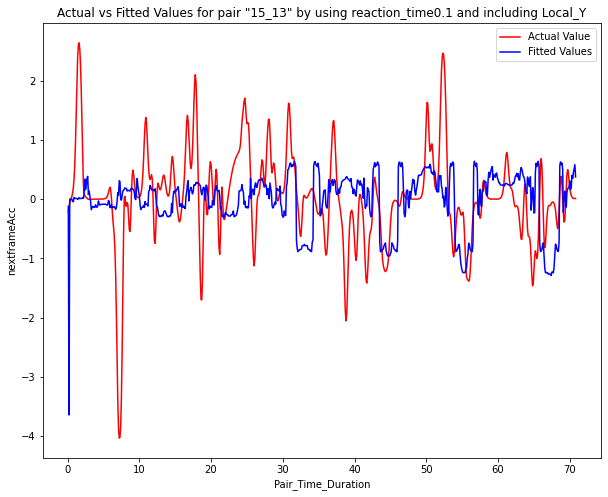

In [33]:
#nextframeAcc
import seaborn as sns
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["Pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values for pair "15_13" by using reaction_time0.1 and including Local_Y')


plt.show()
plt.close()

In [30]:

def accuracy(F):
    mae_score = mean_absolute_error(F['sacc'], F['pacc'])
    r2_scores = r2_score(F['sacc'], F['pacc'])
    return mae_score, r2_scores

In [31]:
accuracy(F)

(0.6961455544194903, -0.1774305454809817)

In [32]:
rf

RandomForestRegressor(n_estimators=150, n_jobs=-1)